In [4]:
from tensorflow import keras

model = keras.models.load_model('convnet_from_scratch.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

In [7]:
import numpy as np
import keras

# 이미지 파일을 다운로드합니다.
img_path = keras.utils.get_file(
    fname='cat.jpg',
    origin='https://img-datasets.s3.amazonaws.com/cat.jpg'
)

def get_img_array(img_path, target_size):
    # 이미지 파일을 target_size 크기로 불러옵니다.
    img = keras.utils.load_img(img_path, target_size=target_size)
    # 이미지를 Numpy 배열로 변환합니다.
    array = keras.utils.img_to_array(img)
    # 차원을 늘립니다.
    array = np.expand_dims(array, axis=0)
    return array

# 이미지를 (180, 180) 크기로 불러와 Numpy 배열로 변환한 후 차원을 늘립니다.
img_tensor = get_img_array(img_path, target_size=(180, 180))

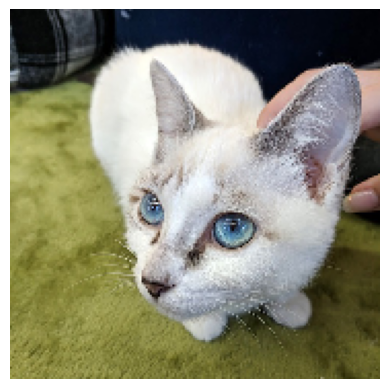

In [12]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [15]:
from tensorflow.keras import layers

layer_outputs = [] # 중간층 출력
layer_names = [] # 중간층 이름

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)): # 레이어가 Conv2D, MaxPooling2D인 경우,
        layer_outputs.append(layer.output)
        layer_names.append(layer.name) # 해당 부분에 저장

activation_model = keras.Model(model.input, layer_outputs)

In [14]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 207ms/step


In [16]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 178, 178, 32)

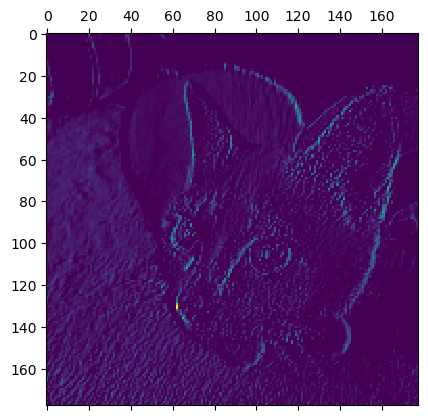

In [17]:
plt.matshow(first_layer_activation[0, :, :, 5]) # 0 : 첫번째 층, 5 : 6번째 채널(index5) - 2D 평면을 출력하겠다.
plt.show()

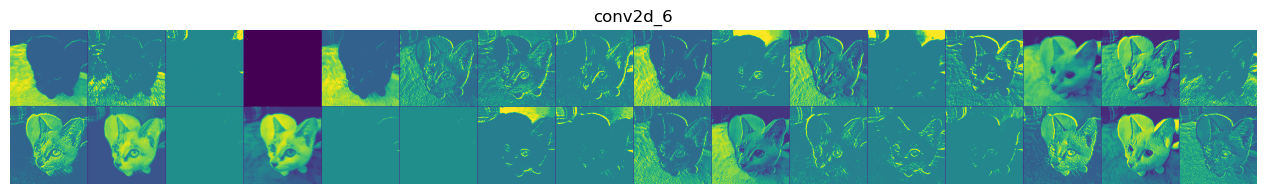

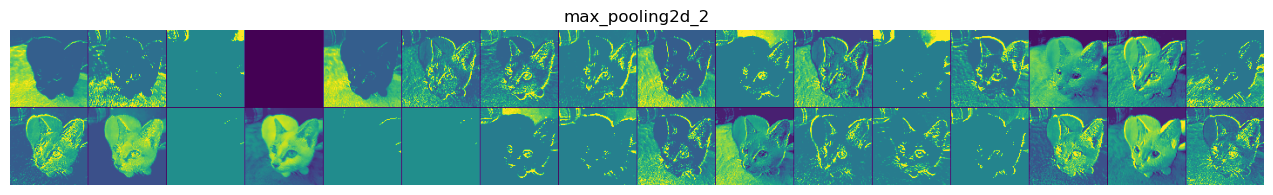

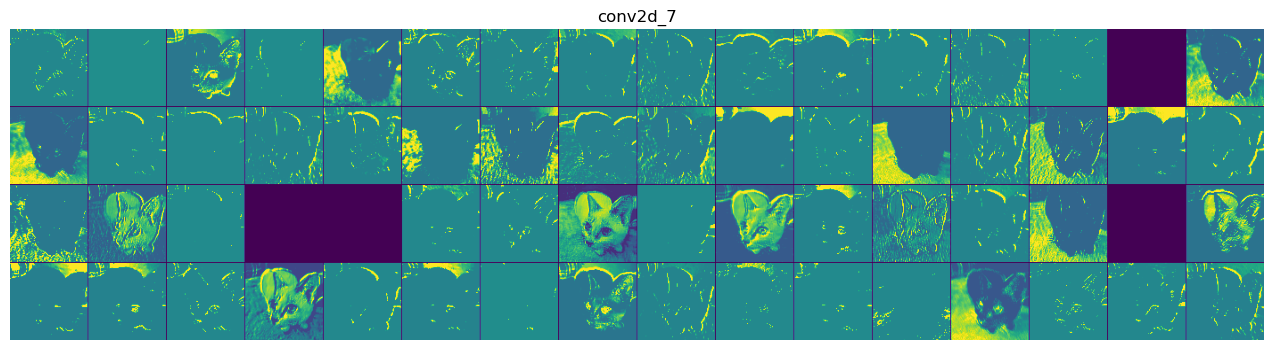

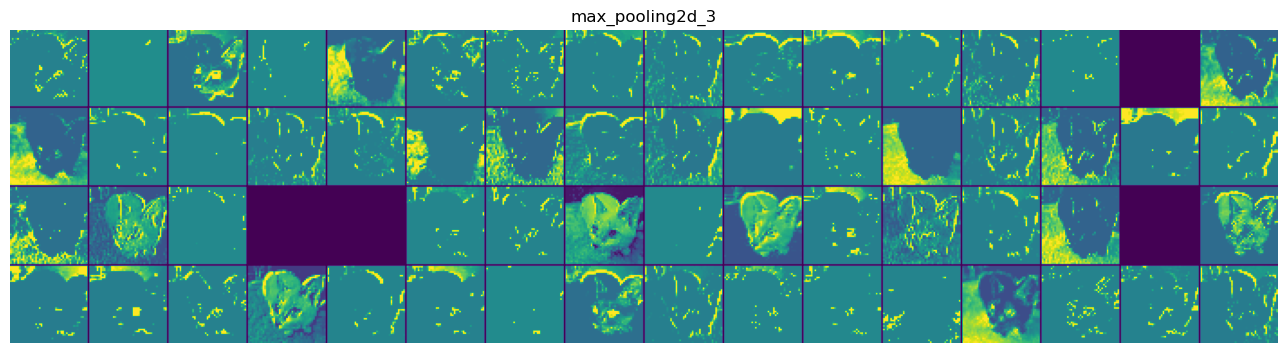

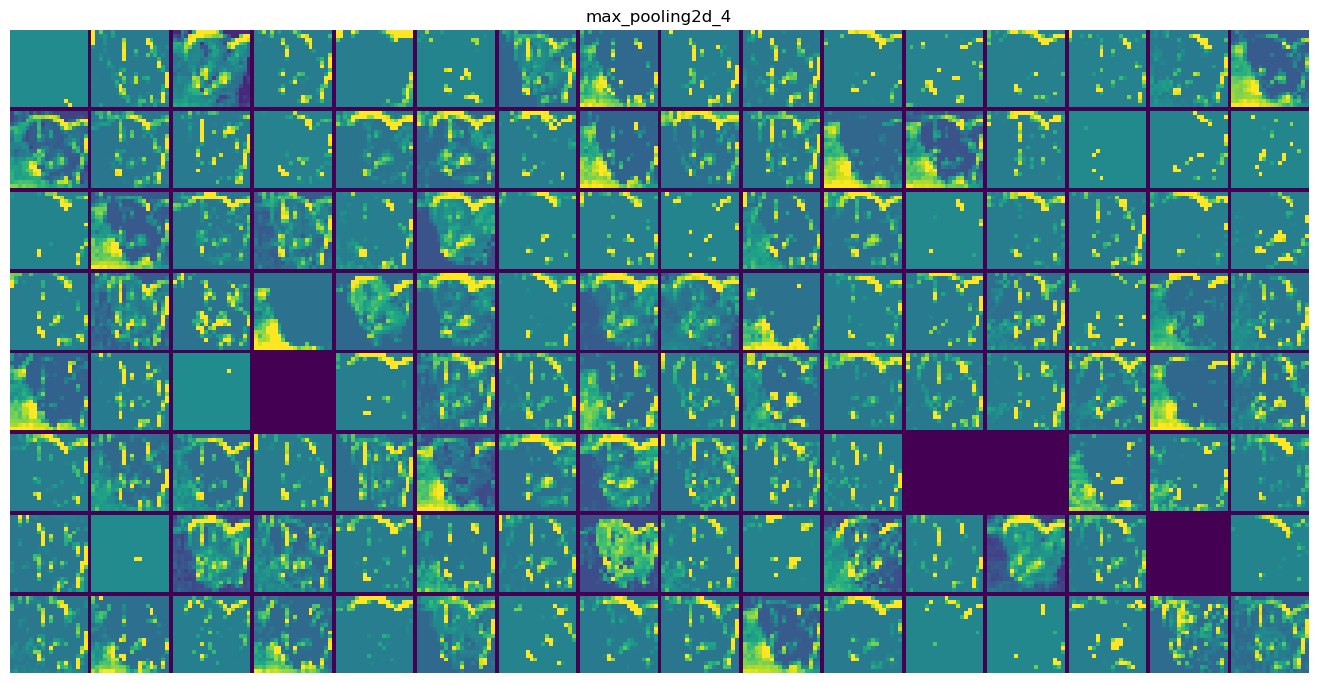

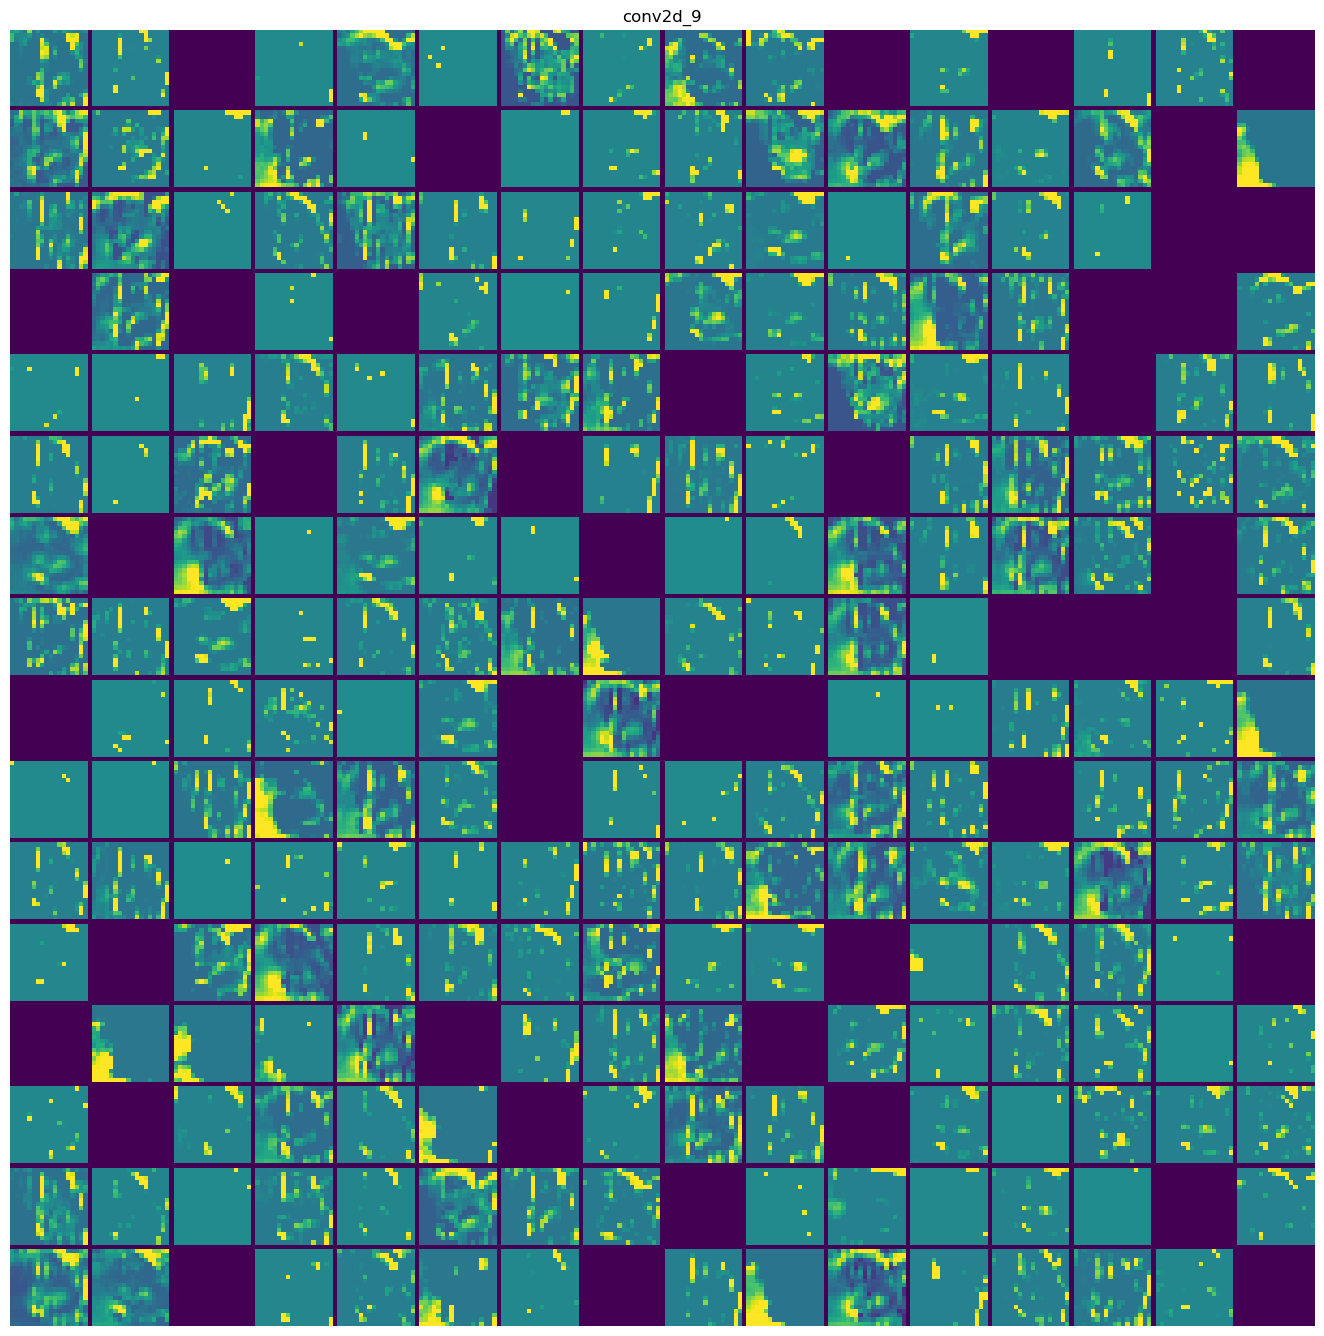

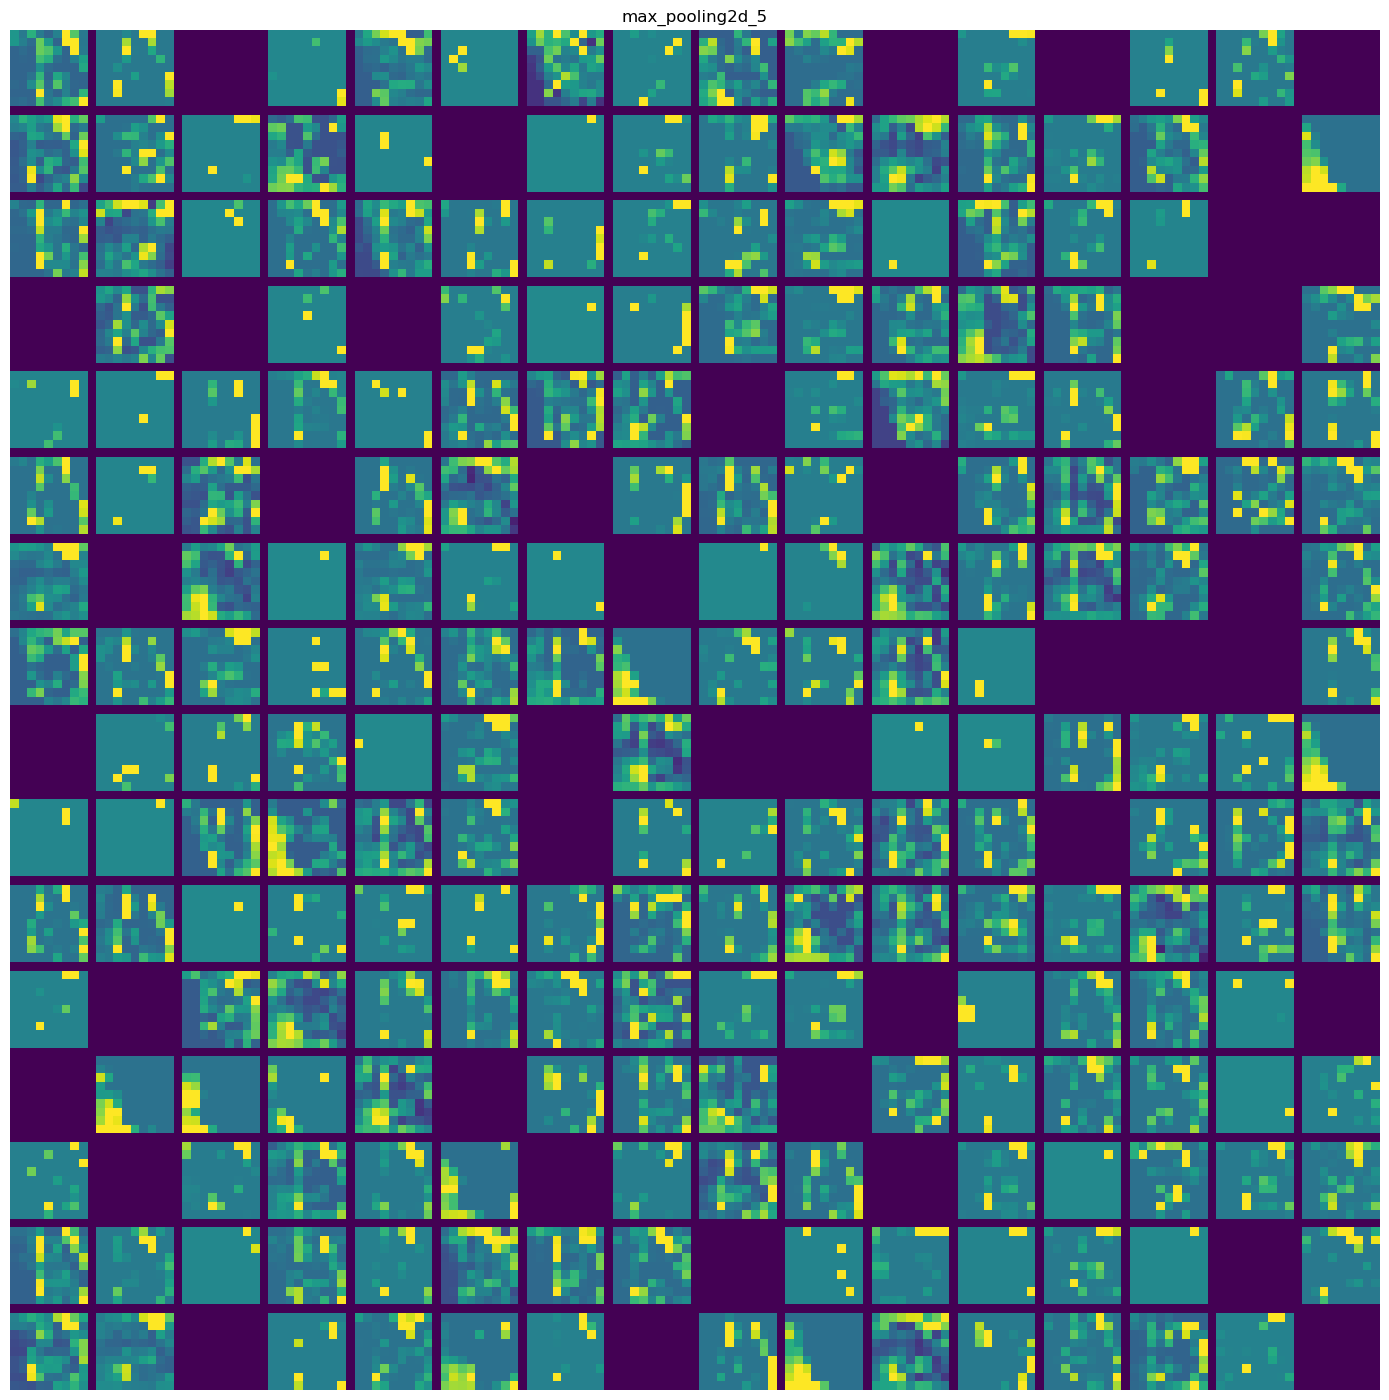

In [21]:
images_per_row = 16 # 한 행에 표시할 채널(특징 맵)의 수

for layer_name, layer_activation in zip(layer_names, activations): # 각 층의 이름과 활성화 값을 반복문을 활용하여 꺼내와준다.
    n_features = layer_activation.shape[-1] # 현재 층의 활성화 값에서 채널의 수
    size = layer_activation.shape[1] # 활성화 값의 가로/세로 크기
    n_cols = n_features // images_per_row # 각 층에서 몇 개의 열을 사용할지 지정해준다.
    display_grid = np.zeros(((size+1)*n_cols-1, images_per_row*(size+1)-1)) # 전체 그리드 이미지

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col*images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy() # 활성화 값에서 특정 인덱스 이미지를 복사

            if channel_image.sum() != 0: # 활성화 값이 존재하는 경우
                channel_image -= channel_image.mean() # 평균을 빼준다.(중심을 0으로 이동시킨다.)
                channel_image /= channel_image.std() # 표준편차로 나눈다.(분산을 1로 맞춘다.)
                channel_image *= 64
                channel_image += 128 # 0~255 범위에 맞추기 위해서 적하한 값으로 변환

            channel_image = np.clip(channel_image, 0, 255).astype('uint8') # 값의 범위를 0~255로 제한한다.
            display_grid[ 
                col*(size+1) : (col+1) * size + col,
                row*(size+1) : (row+1)*size+row] = channel_image # display_grid에 적절한 위치에 channel_image를 넣어준다.

    scale = 1./size # 스케일 조절(사이즈를 나눠주는 방식으로)
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))

    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto')

# Xception(Extreme Inception)
: Depthwise Separable Convolution 기법을 사용한 합성곱 계층
- 공간적 특성과 채널 간의 특성을 분리하여 처리하는 특징을 가지고 있다.

## Depthwise Separable Convolution
1. Depthwise Convolution
- 각 입력 채널에 별도의 합성곱 필터를 적용한다.(공간적 특징을 추출)
- (H x W x C) 크기의 이미지가 입력되었다면, C에 대해 다른 필터를 적용한다.
   
2. Pointwise Convolution
- 1 x 1 합성곱을 사용하여 채널 간의 상호작용을 저장한다.
- Depthwise Convolution의 출력과 결합하여 새로운 특징맵을 만든다.

#### 장점
- 위 방법을 사용하게 되면, 필터 수와 계산량을 줄일 수 있기 때문에 계산 비용을 크게 줄일 수 있다.
- 기울기 소실 문제를 해결하고 학습을 안정화시킬 수 있다.
- 깊고 넓은 신경망 구조로 복잡한 데이터 또한 잘 학습할 수 있다.

#### 구성요소
1. Entry Flow
    - 모델의 시작 부분으로 기본적인 특징을 추출한다.
    - Depthwise Separable Convolution과 Max Pooling 레이어로 구성되어 있다.

2. Middle Flow
    - 입력 특징을 더 깊게 학습한다.
    - 동일한 구조의 반복되어 있는 Depthwise Separable Convolution 블록들로 구성되어 있다.
    - 위 블록들은 잔차연결을 통해 입력과 출력을 연결하여 학습 안정화를 돕는다.

3. Exit Flow
    - 최종 특징을 추출하고 분류를 수행한다.
    - Depthwise Separable Convolution, Global Average Pooling, Fully Connected 레이어로 구성되어 있다.

In [22]:
model = keras.applications.xception.Xception(
    weights = 'imagenet',
    include_top=False)

83683744/83683744 [==============================] - 3s 0us/step


In [26]:
# Xception에 있는 모든 합성곱 층의 이름 출력하기
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [30]:
# 모델 제작
layer_name = 'block3_sepconv1' # 중간층 레이어를 하나 가져와서
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(model.input, layer.output) # 입력은 그대로, 출력에 모델 설정(새로운 모델(=중간층 특징 출력))

In [31]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor) # Xception 모델에 맞게 이미지 전처리
)

In [35]:
def compute_loss(image, filter_index): # 이미지와 필터 인덱스를 통해 손실값 계산
    activation = feature_extractor(image) # 위에서 제작한 feature_extractor 모델을 통해 입력 이미지의 중간층 출력을 계산한다.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] # 특징 맵에서 중앙 부분(2:-2, 2:-2) filter_index번째 출력을 가져온다.
    return tf.reduce_mean(filter_activation) # 필터 활성화 값의 평균을 가져온다.

In [40]:
import tensorflow as tf
# 확률적 경사 상승법을 통한 손실 최소화(이미지 최적화)
@tf.function # Tensorflow 그래프로 컴파일하여 성능을 향상
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image) # 계산 그래프 기록 
        loss = compute_loss(image, filter_index) # 해당 이미지로 입력 이미지에 대한 손실 함수 gradient를 계산하겠다.

    grads = tape.gradient(loss, image) # 손실함수에 대한 gradient를 계산
    grads = tf.math.l2_normalize(grads) # gradient를 L2 정규화(방향만 고려)
    image += learning_rate * grads # 이미지 업데이터
    return image

In [46]:
# 필터 시각화
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30 # 반복 횟수 설정
    learning_rate = 10. # 학습률 설정
    image = tf.random.uniform( # 초기 이미지 세팅(랜덤)(0.4~0.6 사이의 랜덤 값) 사이즈는 (1, 200, 200, 3)
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))

    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate) # 이미지 업데이트

    return image[0].numpy() # 최적화된 이미지 (Numpy 배열)

In [48]:
# 텐서를 이미지로 변환
def deprocess_image(image):
    image -= image.mean() # 이미지의 중심을 0으로 만든다.(밝기 조정)
    image /= image.std() # 표준편차로 나누어 분산을 1로 만들어준다.(대비 조정)
    image *= 64 
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    image = image[25:-25, 25:-25, :] # 가장자리 부분을 제거
    return image

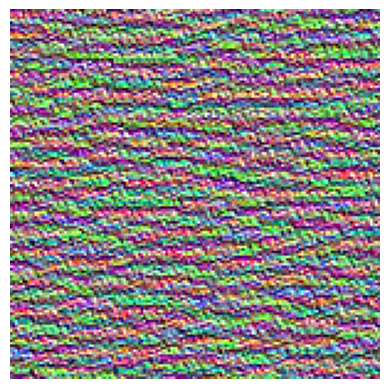

In [49]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

In [54]:
# 모든 필터 출력
all_images = []

for filter_index in range(64):
    print(f'{filter_index}번 필터 처리중')
    image = deprocess_image( # 이미지화
        generate_filter_pattern(filter_index) # 패턴 시각화
    )
    all_images.append(image) 

margin = 5 # 이미지 사이의 간격(마진)
n = 8 # 행과 열 개수(8*8)

cropped_width = img_width - 25 * 2 # 기존 이미지 사이즈에서 사이즈 조정(이미지 하나의 크기)
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n-1) * margin
height = n * cropped_height + (n-1) * margin # 필터 전체 사이즈(전체 출력 이미지의 크기)
stitched_filters = np.zeros((width, height, 3)) # 모든 필터 이미지를 결합하여 저장할 배열

for i in range(n):
    for j in range(n):
        image = all_images[i*n+j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f'filters_for_layer_{layer_name}.png', stitched_filters)

0번 필터 처리중
1번 필터 처리중
2번 필터 처리중
3번 필터 처리중
4번 필터 처리중
5번 필터 처리중
6번 필터 처리중
7번 필터 처리중
8번 필터 처리중
9번 필터 처리중
10번 필터 처리중
11번 필터 처리중
12번 필터 처리중
13번 필터 처리중
14번 필터 처리중
15번 필터 처리중
16번 필터 처리중
17번 필터 처리중
18번 필터 처리중
19번 필터 처리중
20번 필터 처리중
21번 필터 처리중
22번 필터 처리중
23번 필터 처리중
24번 필터 처리중
25번 필터 처리중
26번 필터 처리중
27번 필터 처리중
28번 필터 처리중
29번 필터 처리중
30번 필터 처리중
31번 필터 처리중
32번 필터 처리중
33번 필터 처리중
34번 필터 처리중
35번 필터 처리중
36번 필터 처리중
37번 필터 처리중
38번 필터 처리중
39번 필터 처리중
40번 필터 처리중
41번 필터 처리중
42번 필터 처리중
43번 필터 처리중
44번 필터 처리중
45번 필터 처리중
46번 필터 처리중
47번 필터 처리중
48번 필터 처리중
49번 필터 처리중
50번 필터 처리중
51번 필터 처리중
52번 필터 처리중
53번 필터 처리중
54번 필터 처리중
55번 필터 처리중
56번 필터 처리중
57번 필터 처리중
58번 필터 처리중
59번 필터 처리중
60번 필터 처리중
61번 필터 처리중
62번 필터 처리중
63번 필터 처리중


In [56]:
# 저장한 파일을 가져와서 시각화 작업 진행
from IPython.display import Image

Image(f'filters_for_layer_{layer_name}.png')

In [57]:
# 마지막으로 xception 사용
model = keras.applications.xception.Xception(weights='imagenet')

91884032/91884032 [==============================] - 3s 0us/step


In [58]:
img_path = keras.utils.get_file(
    fname = 'elephant.jpg',
    origin = "https://img-datasets.s3.amazonaws.com/elephant.jpg")

733657/733657 [==============================] - 1s 1us/step


In [61]:
import numpy as np
import keras

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [62]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.8699269), ('n01871265', 'tusker', 0.07696849), ('n02504013', 'Indian_elephant', 0.023537247)]


In [63]:
np.argmax(preds[0])

386

In [72]:
# 마지막 합성곱 출력을 반환하는 모델
last_conv_layer_name = 'block14_sepconv2_act' # 마지막 합성곱 레이어
classifier_layer_names = [ # 분류기에서 사용되는 레이어 이름 
    'avg_pool', 
    'predictions',
]

last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [73]:
# 마지막 합성곱 출력 위에 있는 분류기에 적용할 모델
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)

classifier_model = keras.Model(classifier_input, x) # 분류기 모델

In [81]:
# 최상위 예측 클래스의 그레디언트 계산
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
# top_class_channel에 대한 마지막 합성곱 레이어의 출력의 그레디언트 계산

In [82]:
# gradient 평균, 채널 중요도 가중치 적용
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # 각 채널에 대해 평균 계산
last_conv_layer_output = last_conv_layer_output.numpy()[0] # tensor를 Numpy 배열로 변환
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i] # 각 채널에 중요도를 곱한다.

heatmap = np.mean(last_conv_layer_output, axis=-1) # 각 채널의 가중치가 적용된 출력을 평균내어 히트맵을 만든다.

In [84]:
heatmap = np.maximum(heatmap, 0) # 정규화
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [87]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255*heatmap) # 0~255 범위 uint8 데이터 타입

jet = cm.get_cmap('jet') # color map -jet : 파란색, 녹색, 노란색, 빨간색으로 진행되는 함수
jet_colors = jet(np.arange(256))[:, :3] # 컬러맵의 색상 출력(RGB의 형태의 색상 값을 추출)
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img # 원본 이미지와 히트맵 이미지를 0.6:0.4의 비율로 합성한다.
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'elephant_cam.jpg'
superimposed_img.save(save_path)

/var/folders/mr/zpw8mcz14pj_gkyqs4k_zl4c0000gn/T/ipykernel_1549/285530188.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


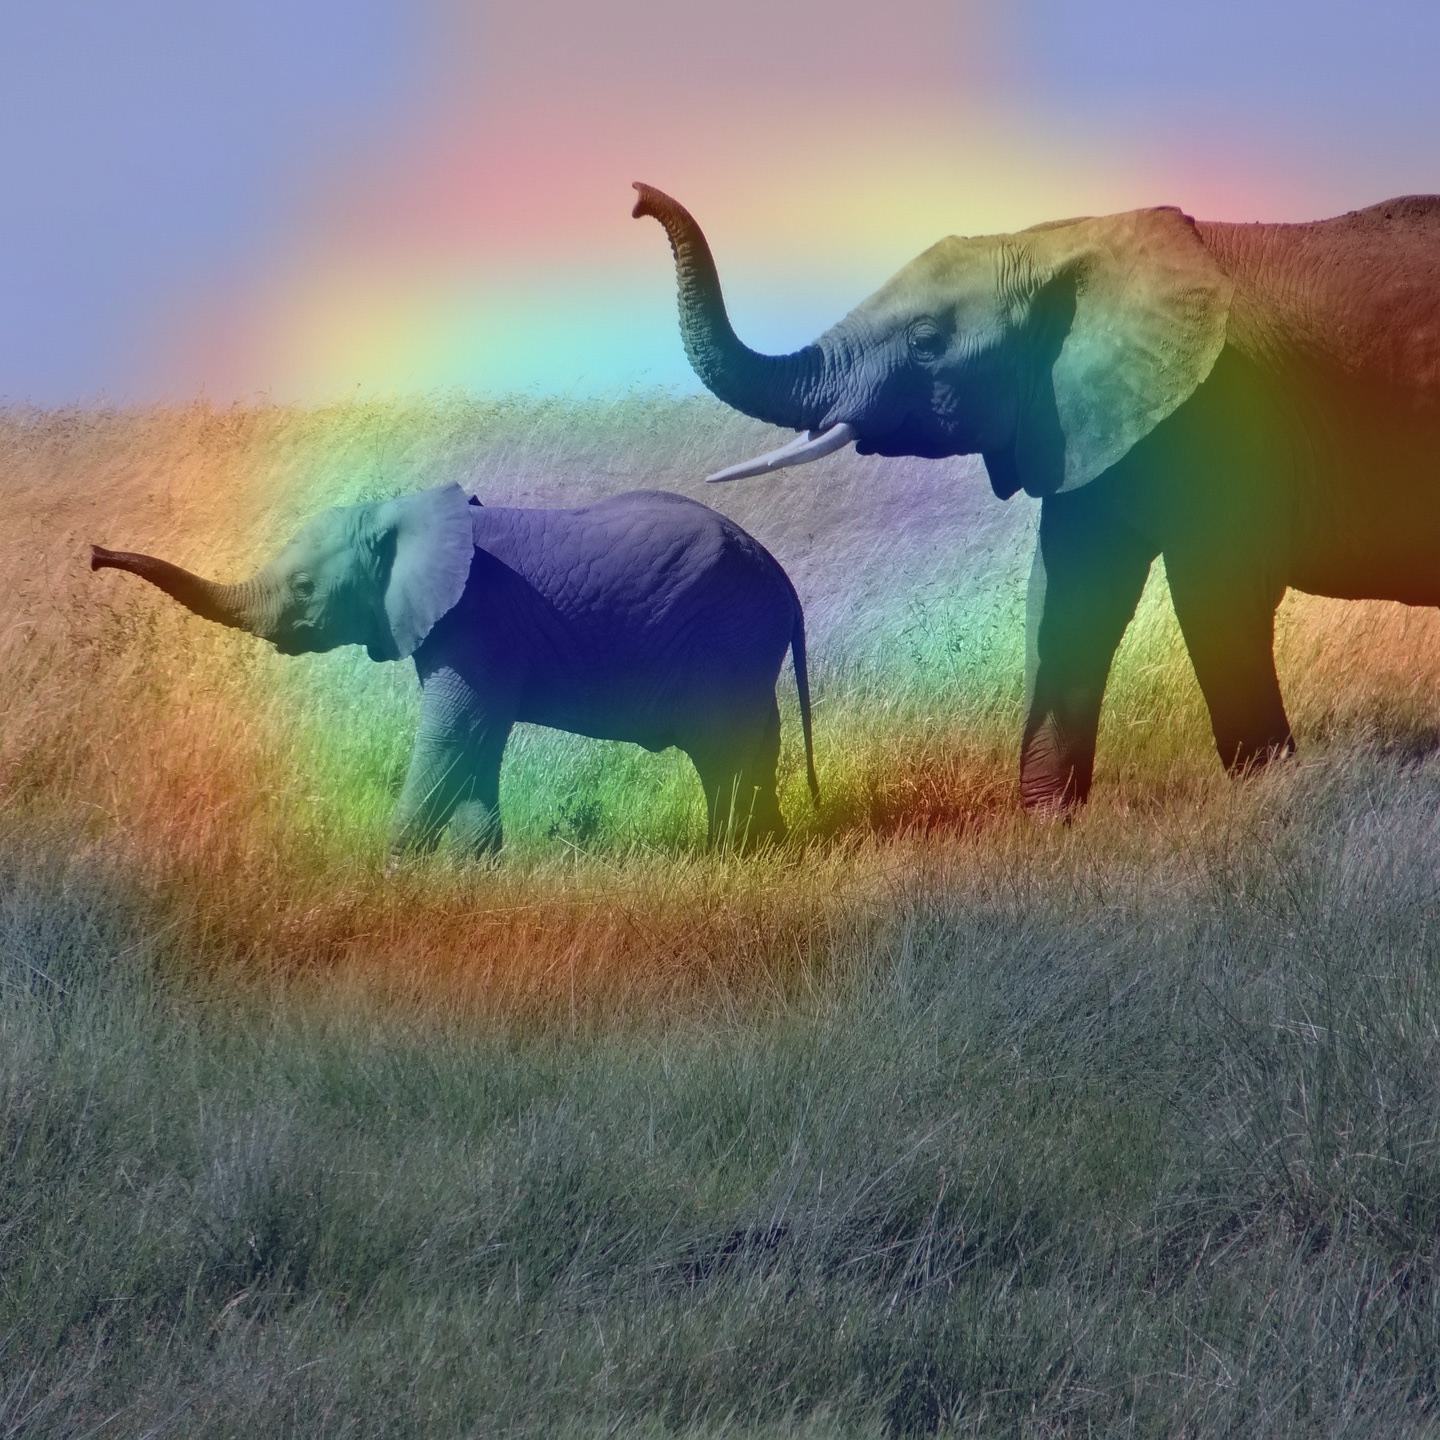

In [88]:
Image('elephant_cam.jpg')